# Treinamento e Avaliação de Modelos de Classificação de Falhas

Este notebook treina três modelos (XGBoost, QDA e SVM) para classificar falhas em rolamentos com base em atributos extraídos.

**Dados de Entrada**:
*   `data/df_treino_com_atributos.pkl`
*   `data/df_teste_com_atributos.pkl`

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
import xgboost as xgb

# Configuração de plot
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)

## 1. Carregamento dos Dados

In [2]:
# Caminhos relativos
base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, 'data')

path_treino = os.path.join(data_dir, 'df_treino_com_atributos.pkl')
path_teste = os.path.join(data_dir, 'df_teste_com_atributos.pkl')

print(f"Carregando {path_treino}...")
df_treino = pd.read_pickle(path_treino)

print(f"Carregando {path_teste}...")
df_teste = pd.read_pickle(path_teste)

print(f"Treino shape: {df_treino.shape}")
print(f"Teste shape: {df_teste.shape}")

Carregando c:\Users\Cliente\Documents\GitHub\TCC\data\df_treino_com_atributos.pkl...
Carregando c:\Users\Cliente\Documents\GitHub\TCC\data\df_teste_com_atributos.pkl...
Treino shape: (1910, 13)
Teste shape: (4624, 13)


## 2. Pré-processamento e Seleção de Features

In [3]:
# Definição das Features (X) e Target (y)
features = [
    'TF2_std', 'TF3_rms', 'TF4_fator_forma', 
    'FF2_freq_central', 'FF3_rms_freq', 'FF5_assimetria_espectral', 
    'FF_pico_50_200Hz', 'rpm'
]
target_col = 'tipo_falha_adicionada'

print(f"Features selecionadas ({len(features)}): {features}")

# Filtrando colunas
X_train = df_treino[features].copy()
y_train_raw = df_treino[target_col].copy()

X_test = df_teste[features].copy()
y_test_raw = df_teste[target_col].copy()

# Codificação das classes (Label Encoding)
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

class_names = le.classes_
print("Classes identificadas:", class_names)

# Normalização dos dados (Importante para SVM e ajuda em geral)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dataframes normalizados para visualização se necessário
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features)

Features selecionadas (8): ['TF2_std', 'TF3_rms', 'TF4_fator_forma', 'FF2_freq_central', 'FF3_rms_freq', 'FF5_assimetria_espectral', 'FF_pico_50_200Hz', 'rpm']
Classes identificadas: ['Esfera' 'Normal' 'Pista Externa' 'Pista Interna']


## 3. Treinamento e Avaliação

In [4]:
def plot_confusion_matrix(y_true, y_pred, title, classes):
    cm = confusion_matrix(y_true, y_pred)
    # Normalized CM for better insight
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Matriz de Confusão - {title}')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.show()
    
    print(f"\nRelatório de Classificação: {title}\n")
    print(classification_report(y_true, y_pred, target_names=classes))

### 3.1 XGBoost Classifier

Treinando XGBoost...
Acurácia XGBoost: 0.3480


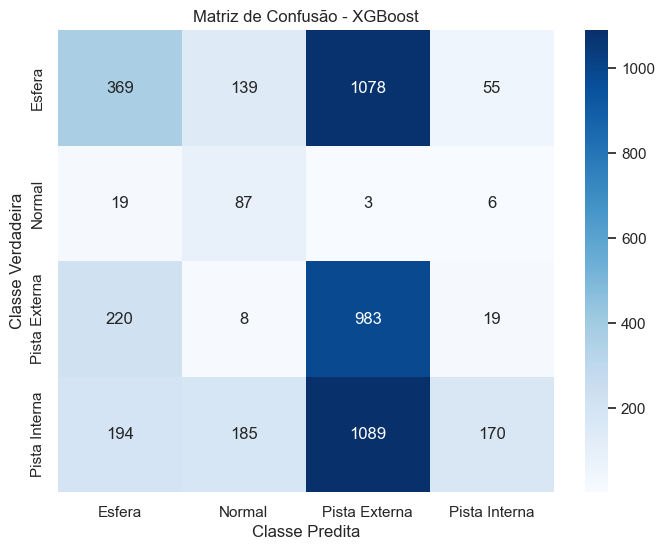


Relatório de Classificação: XGBoost

               precision    recall  f1-score   support

       Esfera       0.46      0.22      0.30      1641
       Normal       0.21      0.76      0.33       115
Pista Externa       0.31      0.80      0.45      1230
Pista Interna       0.68      0.10      0.18      1638

     accuracy                           0.35      4624
    macro avg       0.41      0.47      0.31      4624
 weighted avg       0.49      0.35      0.30      4624



In [13]:
print("Treinando XGBoost...")
model_xgb = xgb.XGBClassifier(
    objective='multi:softprob', 
    random_state=42,
    n_estimators=100,
    eval_metric='mlogloss'
)

model_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = model_xgb.predict(X_test_scaled)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Acurácia XGBoost: {acc_xgb:.4f}")

plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost", class_names)

### 3.2 Quadratic Discriminant Analysis (QDA)

Treinando QDA...
Acurácia QDA: 0.3413


C:\Users\Cliente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


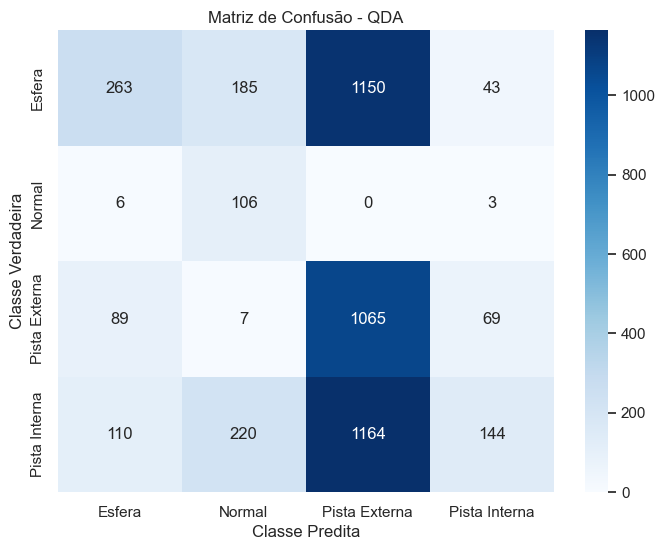


Relatório de Classificação: QDA

               precision    recall  f1-score   support

       Esfera       0.56      0.16      0.25      1641
       Normal       0.20      0.92      0.33       115
Pista Externa       0.32      0.87      0.46      1230
Pista Interna       0.56      0.09      0.15      1638

     accuracy                           0.34      4624
    macro avg       0.41      0.51      0.30      4624
 weighted avg       0.49      0.34      0.27      4624



In [5]:
print("Treinando QDA...")
model_qda = QuadraticDiscriminantAnalysis()

model_qda.fit(X_train_scaled, y_train)
y_pred_qda = model_qda.predict(X_test_scaled)

acc_qda = accuracy_score(y_test, y_pred_qda)
print(f"Acurácia QDA: {acc_qda:.4f}")

plot_confusion_matrix(y_test, y_pred_qda, "QDA", class_names)

### 3.3 Support Vector Machine (SVM)

Treinando SVM (Kernel RBF)...
Acurácia SVM: 0.4416


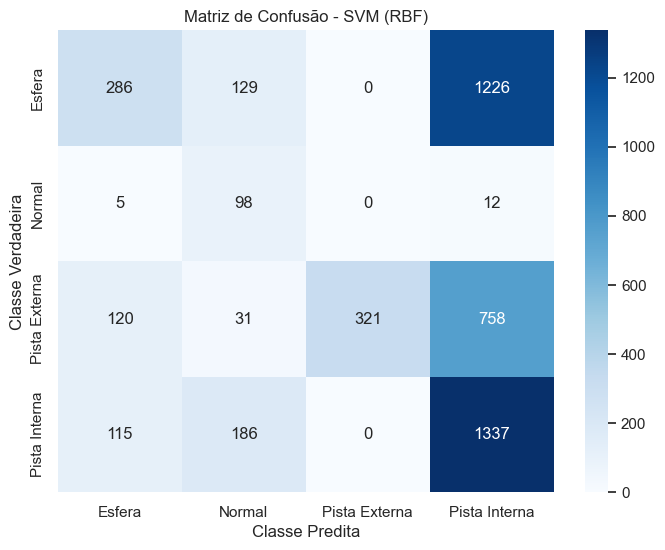


Relatório de Classificação: SVM (RBF)

               precision    recall  f1-score   support

       Esfera       0.54      0.17      0.26      1641
       Normal       0.22      0.85      0.35       115
Pista Externa       1.00      0.26      0.41      1230
Pista Interna       0.40      0.82      0.54      1638

     accuracy                           0.44      4624
    macro avg       0.54      0.53      0.39      4624
 weighted avg       0.61      0.44      0.40      4624



In [7]:
print("Treinando SVM (Kernel RBF)...")
model_svm = SVC(kernel='rbf', C=1.0, random_state=42)

model_svm.fit(X_train_scaled, y_train)
y_pred_svm = model_svm.predict(X_test_scaled)

acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Acurácia SVM: {acc_svm:.4f}")

plot_confusion_matrix(y_test, y_pred_svm, "SVM (RBF)", class_names)

## 4. Comparativo Final

,Modelo,Acurácia
0,XGBoost,0.347967
1,QDA,0.363754
2,SVM,0.472967


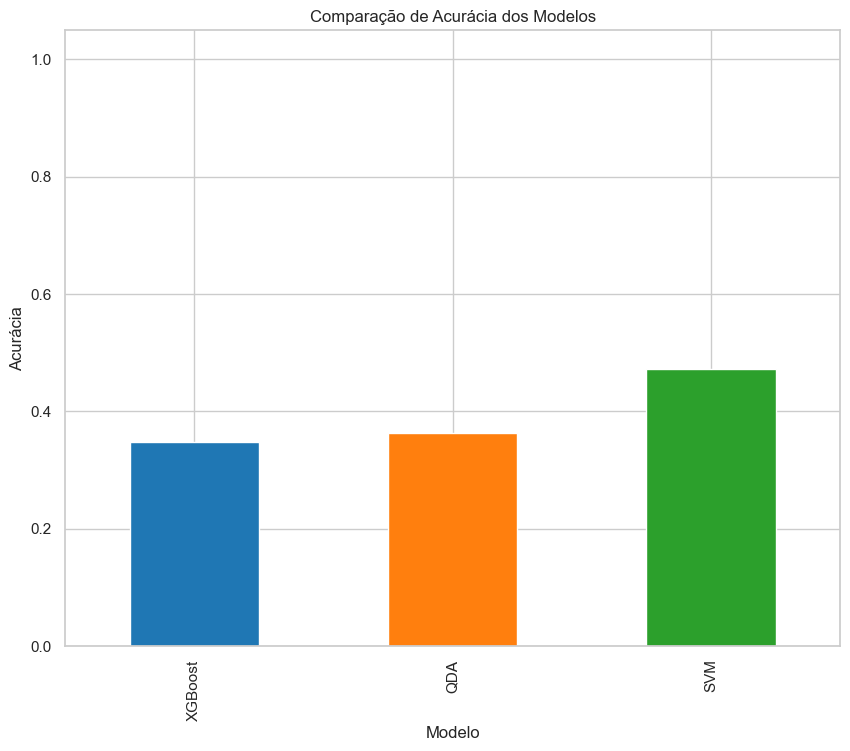

In [8]:
resultados = {
    'Modelo': ['XGBoost', 'QDA', 'SVM'],
    'Acurácia': [acc_xgb, acc_qda, acc_svm]
}

df_res = pd.DataFrame(resultados)
display(df_res)

df_res.plot(x='Modelo', y='Acurácia', kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'], legend=False)
plt.title('Comparação de Acurácia dos Modelos')
plt.ylabel('Acurácia')
plt.ylim(0, 1.05)
plt.show()